##Import the necessary Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-11cc9f23b7ed>:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##Get the Data and do Pandas Cleaning

In [ ]:
!wget https://www.dropbox.com/s/poqpk4528x4nkp3/spa.txt #Download the datafile from this site

--2023-04-26 04:31:54--  https://www.dropbox.com/s/poqpk4528x4nkp3/spa.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/poqpk4528x4nkp3/spa.txt [following]
--2023-04-26 04:31:55--  https://www.dropbox.com/s/raw/poqpk4528x4nkp3/spa.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc198100c6036b47e0205cb57a3f.dl.dropboxusercontent.com/cd/0/inline/B655fJViPeFP1yJdx6EAahIvKagZYHZj2sW-jar2SQXbf18CjJY_UU8izLdxvFOvX3OKgf2hnIo-gtLWA3EfHAb1vNT35B1CrpINIThRCVD-XM5iSA5iV20c_UbTX-UmN1Dz9twS5X-8F_f6pRkcZk5kkMiV7Ai_NJ-Z3sbtK0q_QQ/file# [following]
--2023-04-26 04:31:55--  https://uc198100c6036b47e0205cb57a3f.dl.dropboxusercontent.com/cd/0/inline/B655fJViPeFP1yJdx6EAahIvKagZYHZj2sW-jar2SQXbf18CjJY_UU8izLdxvFOvX3OKgf2hnIo-gtLWA3EfHAb1vNT35B1

In [ ]:
fi = open("/content/spa.txt",encoding='utf-8',mode='r')
data = fi.read()

In [ ]:
mylist=[]
for line in data.split('\n'):
  mylist.append(line.split('\t'))

In [ ]:
lines=pd.DataFrame(mylist)

lines = lines.iloc[:,:2]  #we are taking only the first 2 columns.
lines.columns=['english','spanish']
lines.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,VÃ¡yase.
4,Hi.,Hola.


In [ ]:
lines.shape

(123771, 2)

In [ ]:
lines.dropna(inplace=True)
lines.shape

(123770, 2)

In [ ]:
lines.drop_duplicates(inplace=True)
lines=lines.sample(n=120000,random_state=42)
lines.shape

(120000, 2)

In [ ]:
lines.head()

,english,spanish
112706,Tom entered his office and saw a box on his desk.,Tom entrÃ³ a su oficina y vio una caja sobre el escritorio.
39299,The trees were in a row.,Los Ã¡rboles estaban en lÃ­nea.
115199,My uncle went to Mexico in 1983,never to come back.
39449,This book is very heavy.,Este libro es muy pesado.
11509,I'm sure of this.,Estoy bastante seguro.


In [ ]:
lines.loc[7968]

english    Do you know her?
spanish    Â¿La conocen?   
Name: 7968, dtype: object

##Clean the Text data

In [ ]:
# Lowercase all characters
lines['english']=lines['english'].apply(lambda x: x.lower())
lines['spanish']=lines['spanish'].apply(lambda x: x.lower())

# Remove quotes
lines['english']=lines['english'].apply(lambda x: re.sub("'", '', x)) #Ex. I'm sure of this --> Im sure of this
lines['spanish']=lines['spanish'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters i.e. It gives all punctuations as a String
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['spanish']=lines['spanish'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits) #we have imported digits from string
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['spanish']=lines['spanish'].apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['spanish']=lines['spanish'].apply(lambda x: x.strip())
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x)) #'space' if occurs once or more, replace with 'space'
lines['spanish']=lines['spanish'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines['spanish'] = lines['spanish'].apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.head()

,english,spanish
112706,tom entered his office and saw a box on his desk,START_ tom entrã³ a su oficina y vio una caja sobre el escritorio _END
39299,the trees were in a row,START_ los ã¡rboles estaban en lã­nea _END
115199,my uncle went to mexico in,START_ never to come back _END
39449,this book is very heavy,START_ este libro es muy pesado _END
11509,im sure of this,START_ estoy bastante seguro _END


##Create Vocabularies, Token index and Reverse token index

In [ ]:
#English and Spanish Vocabulary
all_eng_words=set() #set in python ensures that we don't get repeated values
for sent in lines['english']:
    for word in sent.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_spanish_words=set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spanish_words:
            all_spanish_words.add(word)



In [ ]:
input_words = sorted(list(all_eng_words)) #list of english words in sorted order
target_words = sorted(list(all_spanish_words)) #list of spanish wprds in sorted order
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spanish_words)

num_encoder_tokens += 1 #for zero padding
num_decoder_tokens += 1 #for zero padding
print('Encoder tokens:', num_encoder_tokens,'\n' 'Decoder tokens:', num_decoder_tokens)

Encoder tokens: 13142 
Decoder tokens: 28640


In [ ]:
#Token Index
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

#Reverse Token Index
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
items = input_token_index.items()
list(items)[:10]

[('a', 1),
 ('aardvark', 2),
 ('aardvarks', 3),
 ('aaron', 4),
 ('aback', 5),
 ('abandon', 6),
 ('abandoned', 7),
 ('abandoning', 8),
 ('abate', 9),
 ('abated', 10)]

In [ ]:
input_token_index.get('abate')

9

In [ ]:
items = reverse_input_char_index.items()
list(items)[:10]

[(1, 'a'),
 (2, 'aardvark'),
 (3, 'aardvarks'),
 (4, 'aaron'),
 (5, 'aback'),
 (6, 'abandon'),
 (7, 'abandoned'),
 (8, 'abandoning'),
 (9, 'abate'),
 (10, 'abated')]

In [ ]:
reverse_input_char_index.get(9)

'abate'

## Using Maximum sentence length = 20

In [ ]:
lines['length_eng_sentence']=lines['english'].apply(lambda x:len(x.split(" ")))
lines['length_spa_sentence']=lines['spanish'].apply(lambda x:len(x.split(" ")))
lines.head()

,english,spanish,length_eng_sentence,length_spa_sentence
112706,tom entered his office and saw a box on his desk,START_ tom entrã³ a su oficina y vio una caja sobre el escritorio _END,11,14
39299,the trees were in a row,START_ los ã¡rboles estaban en lã­nea _END,6,7
115199,my uncle went to mexico in,START_ never to come back _END,6,6
39449,this book is very heavy,START_ este libro es muy pesado _END,5,7
11509,im sure of this,START_ estoy bastante seguro _END,4,5


In [ ]:
lines = lines[lines['length_eng_sentence']<=20]
lines = lines[lines['length_spa_sentence']<=20]

max_length_src = max(lines['length_spa_sentence'])
max_length_tar = max(lines['length_eng_sentence'])
print('Maximum length of Spanish Sentence:', max_length_src)
print('Maximum length of English Sentence:', max_length_tar)

lines = shuffle(lines)
lines.head()

Maximum length of Spanish Sentence: 20
Maximum length of English Sentence: 20


,english,spanish,length_eng_sentence,length_spa_sentence
115960,mary is always saying that tom isnt romantic enough,START_ marã­a dice siempre que tom no es lo suficientemente romã¡ntico _END,9,12
88198,you dont seem particularly pleased,START_ usted no parece especialmente complacida _END,5,7
42450,i wanted to surprise you,START_ querã­a sorprenderte _END,5,4
85702,he has gone to italy to study music,START_ ãl se ha ido a italia a estudiar mãºsica _END,8,11
122389,tom and mary have been trying to come up with a solution to the problem,START_ tom y marã­a han estado tratando de idear una soluciã³n al problema _END,15,14


In [ ]:
lines.shape
#150 words has length >20, which were removed

(119850, 4)

## Generator to generate the data for mining

In [ ]:
X, y =lines['english'], lines['spanish']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X.shape, X_train.shape, X_test.shape

((119850,), (95880,), (23970,))

In [ ]:
print(X_train[35]) 
print(y[35])

i won
START_ â¡he ganado _END


In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):  #sentence in the 128 sentences
                for t, word in enumerate(input_text.split()): #This is the words in the sentence
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq

                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.  #t-1 is the -1 timestep for each word in 'target_token_index'
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

**1 iteration of the 1st for loop, takes care of 128 records, becuase batchsize=128**

##Create the model

In [ ]:
latent_dim = 300

In [ ]:
# Encoder
#This is not a Sequential model, but a Functional model
#We use functional model because, Sequential model will not allow to take 2 inputs, which a functional model can.
encoder_inputs = Input(shape=(None, ))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
#Decoder
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) #"return_sequences=True" as we need the ouput also in the decoder, but not so with the Encoder. Hence we use only "return_state=True" for encoder
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax') #this will do One-Hot encoding and give the output
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#because we have done One-Hot encoding and got a vector 28640 and softmax, so we use 'categorical_crossentropy'

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    3942600     ['input_1[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, None, 300)    8592000     ['input_3[0][0]']                
                                                                                            

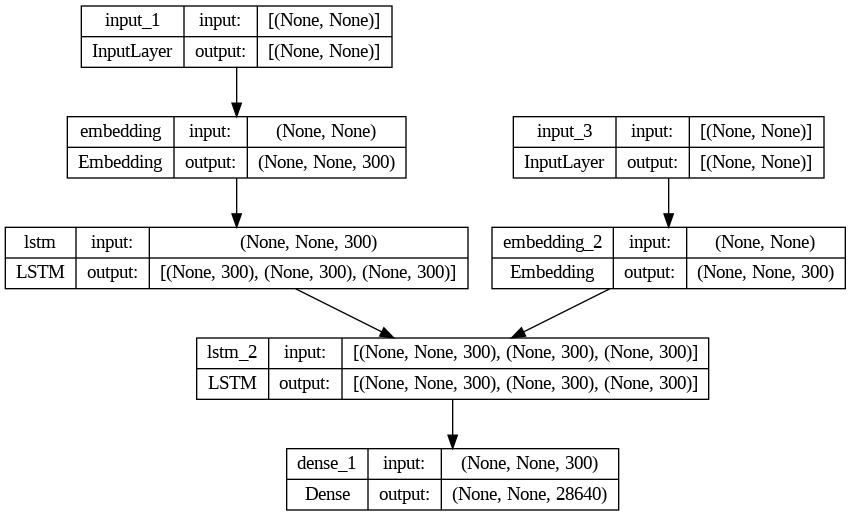

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='machine_translation_model.png', show_shapes=True)

##Train the model

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 10

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

<ipython-input-42-b22c3ec5e69e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/10
749/749 [==============================] - 415s 535ms/step - loss: 6.2663 - val_loss: 6.0315
Epoch 2/10
749/749 [==============================] - 386s 516ms/step - loss: 5.7670 - val_loss: 5.4861
Epoch 3/10
749/749 [==============================] - 387s 516ms/step - loss: 5.2118 - val_loss: 4.9905
Epoch 4/10
749/749 [==============================] - 386s 516ms/step - loss: 4.7890 - val_loss: 4.6506
Epoch 5/10
749/749 [==============================] - 379s 506ms/step - loss: 4.4423 - val_loss: 4.3547
Epoch 6/10
749/749 [==============================] - 387s 517ms/step - loss: 4.1411 - val_loss: 4.0969
Epoch 7/10
749/749 [==============================] - 387s 517ms/step - loss: 3.8886 - val_loss: 3.8901
Epoch 8/10
749/749 [==============================] - 394s 526ms/step - loss: 3.6771 - val_loss: 3.7350
Epoch 9/10
749/749 [==============================] - 388s 519ms/step - loss: 3.4885 - val_loss: 3.5802
Epoch 10/10
749/749 [==============================] - 387s 517m

In [ ]:
model.save_weights('nmt_weights_eng_spa.h5')

In [ ]:
#saved the model to Drive to avoid further training and directly importing when needed
!cp /content/nmt_weights_eng_spa.h5 /content/drive/MyDrive/Machine_Translation

##Load weights from the saved model

In [ ]:
!cp /content/drive/MyDrive/Machine_Translation/nmt_weights_eng_spa.h5 /content
model.load_weights('/content/nmt_weights_eng_spa.h5')

##Inference Model(Generate Translation)

**Inference Description**



1.   Encode the input sentence and retrive the initial decoder state
2.   Run one step of the decoder with its initial state and a 'start of sequence' token as target. The output will be the next target character.


3.  Append the target character predicted and repeat    





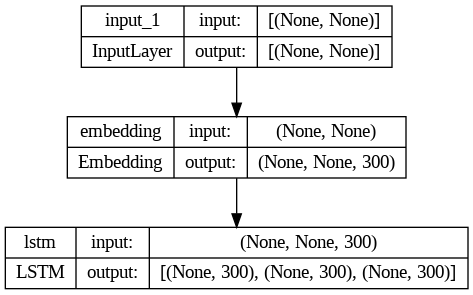

In [ ]:
#Encode the input sequence to get the thought vectors
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file = 'model.png', show_shapes=True)

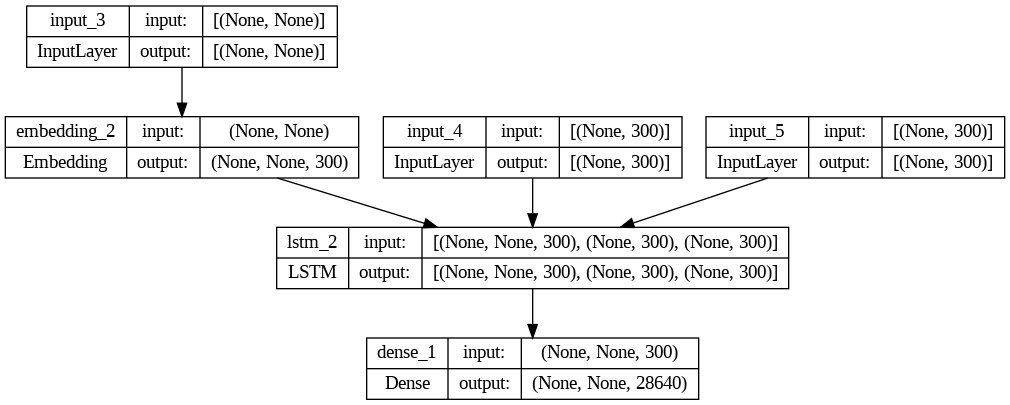

In [ ]:
#Decoder Setup
dec_emb2 = dec_emb_layer(decoder_inputs) #get the embeddings of the decoder sequence
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Spanish Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Spanish Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 34ms/step
Input English sentence: who will you be going to boston with
Actual Spanish Translation:  â¿con quiã©n vas a ir a boston 
Predicted Spanish Translation:  â¿con que nos ayude con boston 


In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Spanish Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Spanish Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 22ms/step
Input English sentence: we learn from our mistakes
Actual Spanish Translation:  aprendemos de nuestros errores 
Predicted Spanish Translation:  he perdido la puerta 
